<a href="https://colab.research.google.com/github/ibagayoko/vfaker/blob/master/VFaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clonage de la voix 

In [0]:
!rm -rf vfaker

In [2]:
import os
from os.path import exists, join, expanduser

# Clone
vocoder_name = "deepvoice3_pytorch"
if not exists(vocoder_name):
  ! git clone https://github.com/ibagayoko/$vocoder_name dv3
    
encoder_name = "vfaker"
if not exists(vocoder_name):
  ! git clone https://github.com/ibagayoko/$encoder_name vfaker

fatal: destination path 'dv3' already exists and is not an empty directory.
Cloning into 'vfaker'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 28 (delta 5), reused 28 (delta 5), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [3]:
! pip install -q librosa nltk lws unidecode nnmnkwii tensorboardX

    100% |████████████████████████████████| 143kB 6.5MB/s 
    100% |████████████████████████████████| 245kB 21.2MB/s 
    100% |████████████████████████████████| 1.7MB 13.3MB/s 
    100% |████████████████████████████████| 133kB 30.1MB/s 
    100% |████████████████████████████████| 368kB 21.7MB/s 
    100% |████████████████████████████████| 430kB 27.0MB/s 


In [3]:
import torch
import numpy as np
import librosa
import librosa.display
import IPython
from IPython.display import Audio
# need this for English text processing frontend
import nltk
! python -m nltk.downloader cmudict

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


### Download a pre-trained model for the vocoder

In [0]:
checkpoint_path = "20171222_deepvoice3_vctk108_checkpoint_step000300000.pth"

In [6]:
if not exists(checkpoint_path):
  !curl -O -L "https://www.dropbox.com/s/uzmtzgcedyu531k/20171222_deepvoice3_vctk108_checkpoint_step000300000.pth"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1034    0  1034    0     0    843      0 --:--:--  0:00:01 --:--:--     0
100  289M  100  289M    0     0  19.9M      0  0:00:14  0:00:14 --:--:-- 36.9M


In [5]:
# Copy preset file (json) from master
# The preset file describes hyper parameters for tthe vocoder (deepvoice3)
preset = "./dv3/presets/deepvoice3_vctk.json"
! cp -v $preset .
preset = "./deepvoice3_vctk.json"

'./dv3/presets/deepvoice3_vctk.json' -> './deepvoice3_vctk.json'


### Setup hyper parameters

In [0]:
from dv3 import hparams
import json

# Newly added params. Need to inject dummy values
for dummy, v in [("fmin", 0), ("fmax", 0), ("rescaling", False),
                 ("rescaling_max", 0.999), 
                 ("allow_clipping_in_normalization", False)]:
  if hparams.get(dummy) is None:
    hparams.add_hparam(dummy, v)
    
# Load parameters from preset
with open(preset) as f:
  hparams.parse_json(f.read())

# Tell we are using multi-speaker DeepVoice3
hparams.builder = "deepvoice3_multispeaker"
  
# Inject frontend text processor
from dv3 import synthesis
from dv3 import train
from dv3.deepvoice3_pytorch import frontend
synthesis._frontend = getattr(frontend, "en")
train._frontend =  getattr(frontend, "en")

# alises
fs = hparams.sample_rate
hop_length = hparams.hop_size

### Define utility functions

In [0]:
def tts(model, text, p=0, speaker_id=0, fast=True, figures=True):
  from dv3.synthesis import tts as _tts
  waveform, alignment, spectrogram, mel = _tts(model, text, p, speaker_id, fast)
  if figures:
      visualize(alignment, spectrogram)
  IPython.display.display(Audio(waveform, rate=fs))
  return mel

  
def visualize(alignment, spectrogram):
  label_fontsize = 16
  figure(figsize=(16,16))

  subplot(2,1,1)
  imshow(alignment.T, aspect="auto", origin="lower", interpolation=None)
  xlabel("Decoder timestamp", fontsize=label_fontsize)
  ylabel("Encoder timestamp", fontsize=label_fontsize)
  colorbar()

  subplot(2,1,2)
  librosa.display.specshow(spectrogram.T, sr=fs, 
                           hop_length=hop_length, x_axis="time", y_axis="linear")
  xlabel("Time", fontsize=label_fontsize)
  ylabel("Hz", fontsize=label_fontsize)
  tight_layout()
  colorbar()

### Load the model checkpoint

In [8]:
from dv3.train import build_model
from dv3.train import restore_parts, load_checkpoint

vocoder = build_model()
vocoder = load_checkpoint(checkpoint_path, vocoder, None, True)

Load checkpoint from: 20171222_deepvoice3_vctk108_checkpoint_step000300000.pth


In [0]:
!mv dv3/Cloning_Audio/ ./Cloning_Audio

In [0]:
cloned_voices = None


In [0]:
import pickle
with open("./Cloning_Audio/speakers_cloned_voices_mel.p" , "rb") as fp:
            cloned_voices = pickle.load(fp)

In [0]:
from dv3.utils import get_cloned_voices, get_embed_speakers
# Values that model should be train on
# cloned_voices = get_cloned_voices(vocoder)

# The ground tru
emdeds = get_embed_speakers(vocoder)

In [0]:
from vfaker.utils import prepareMelSpec
cloned_voices = prepareMelSpec(cloned_voices)

In [0]:
from vfaker.baidu import build_model as build_baidu_encoder
encoder = build_baidu_encoder(N_conv=2)

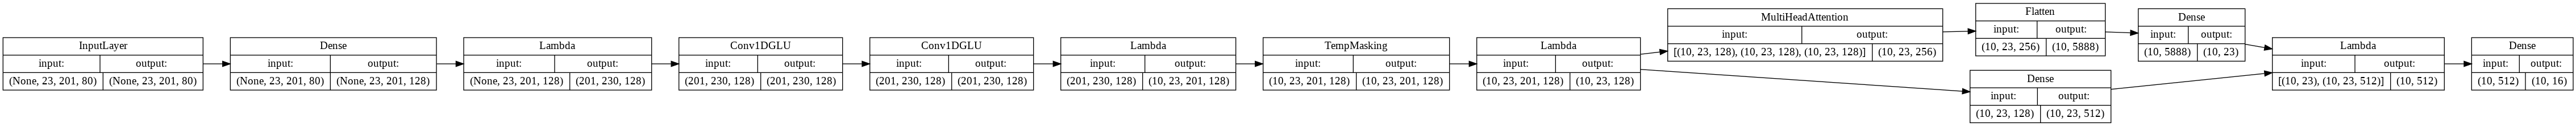

In [27]:
#  source : https://laujohn.com/2018/09/24/Plot-Keras-Model-in-Colaboratory/
from IPython.display import Image
from keras.utils import plot_model

plot_model(encoder, show_layer_names=False, show_shapes=True,  to_file='model.png', rankdir='LR')

Image(retina=True, filename='model.png')

#### Définition de callbacks
- checkpoint afin de ne sauver que le meilleur modèle

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('./baidu_encoder-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5',  monitor='val_loss', verbose=1, save_best_only=True )  
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

In [0]:
# compile the model

encoder.compile(optimizer='adam', loss='mean_absolute_error',  metrics=['acc'])

In [0]:
N_EPOCHS = 10000

In [0]:
X_train = cloned_voices[:100]
y_train = emdeds[:100]

In [49]:
X_train.shape

(100, 23, 201, 80)

In [0]:
import keras
# datagen = keras.preprocessing.image.ImageDataGenerator(validation_split=.2)
# # training_data = datagen.flow(X_train, y_train, subset='training', shuffle=True, batch_size=10)
# val_data = datagen.flow(X_train, y_train, subset='validation', shuffle=True, batch_size=10)

In [41]:
history = encoder.fit_generator(training_data, validation_data=val_data)

NameError: ignored

In [55]:

history = encoder.fit(X_train, 
                      y_train, batch_size=10,  
                      epochs=N_EPOCHS, validation_split=0.2, 
                      callbacks=[checkpoint], verbose=1)

Train on 80 samples, validate on 20 samples
Epoch 1/10000
80/80 [==============================] - 23s 285ms/step - loss: 6.3692 - acc: 0.1375 - val_loss: 5.2903 - val_acc: 0.2000

Epoch 00001: val_loss improved from 6.91126 to 5.29030, saving model to ./baidu_encoder-001-0.137500-0.200000.h5


TypeError: ignored

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(bottom=0)
plt.show()

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()